In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from matplotlib import pylab as plt 
from scipy.stats import norm
import yfinance as yf 
from itertools import accumulate

/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def strategy_evaluation(result, data_names, freq = 'D'):

    
    port = pd.DataFrame(result)
    port_ret = calc_port_ret(port)
    benchmark = port_ret['Benchmark']
    
    metrics = pd.DataFrame([])
    
    if freq == 'D':
    
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'D', benchmark = benchmark).transpose()], 
                               axis = 0)
        metrics.index = data_names
        
    elif freq == 'M':
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], freq = 'M',
                                                    benchmark = benchmark).transpose()], axis = 0)
        metrics.index = data_names
        
    th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]


    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '11px'), ('text-align', 'center')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]

    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=int(len(metrics.columns)), as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=int(len(metrics.columns)), as_cmap=True)

    metrics = (metrics.style
      .background_gradient(axis = 0 ,subset = ['CAGR','Max DD', 'Sharpe','MAR','Sortino', 'IR'],cmap=cm_pos_good)
      .background_gradient(axis = 0 ,subset = ['Volatility', 'Active Risk'],cmap=cm_neg_good)
      #.set_caption('Performance Metrics')
      .format({'CAGR': "{:.1%}", 'Max DD': "{:.1%}", 'Volatility': "{:.1%}",'Active Risk': "{:.1%}",
              'Sharpe': "{:.1f}",'MAR': "{:.2f}", 'Sortino': "{:.1f}",'IR': "{:.2f}" })
      .set_table_styles(styles)
      .set_properties(**{'color': 'black'}))
    
    return metrics


def port_eval(port, freq = 'D', benchmark = None):
    
    port = pd.DataFrame(port)
    port_ret = calc_port_ret(port)
    
    Roll_Max = port.cummax()
    Daily_Drawdown = port/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    
    Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)
    
    neg_ret = port_ret[port_ret<1].dropna()
    
    mean = np.mean(port_ret - 1)
    std = np.std(port_ret - 1)
    
    alpha = 0.05
    ES = round(alpha**-1 * norm.pdf(norm.ppf(alpha))*std - mean,3)
    

    rel_return = port_ret.subtract(benchmark, axis = 0) +1

    
    if freq == 'D':
        cagr = round(port_ret.cumprod().tail(1)**(252/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(252),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(252),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
        active_risk = round(np.log(rel_return).std()*np.sqrt(252),3) 
        excess_return = round(rel_return.cumprod().tail(1)**(252/len(rel_return)) - 1,4)
        IR = round(excess_return/active_risk,2)
        

    
    elif freq == 'M':
        cagr = round(port_ret.cumprod().tail(1)**(12/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,2)
        vol = round(np.log(port_ret).std()*np.sqrt(12),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(12),2)
        sortino = round(cagr/sortino,2)
        sharpe = round(cagr/vol,2)
        
        active_risk = round(np.log(rel_return).std()*np.sqrt(12),3) 
        excess_return = round(rel_return.cumprod().tail(1)**(12/len(rel_return)) - 1,4)
        IR = round(excess_return/active_risk,2)
        
        
    metrics = pd.DataFrame({'': [float(cagr.iloc[0]), float(vol.iloc[0]),
                                 float(sharpe.iloc[0]),float(sortino.iloc[0]),
                                 float(Max_Daily_Drawdown.iloc[0]), abs(float(MAR.iloc[0])),
                                float(active_risk.iloc[0]),float(IR.iloc[0])]},
                  index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR', 'Active Risk',
                         'IR'])
                           
                  #index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR'])
    metrics[metrics.isna()] = 0
    
    return metrics 




def calc_port_ret(port):
    port_ret = port/port.shift(1)
    port_ret = port_ret.fillna(1)
    
    return port_ret

In [3]:
def correlation_map(result):
    ret = calc_port_ret(result)
    ret = np.log(ret)
    corr = ret.corr()
    corr = round(corr, 3)
    th_props = [
      ('font-size', '20px'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', 'Black'),
      ('background-color', '#f7f7f9')
      ]

    
        # Set CSS properties for td elements in dataframe
    td_props = [
          ('font-size', '20px'), ('text-align', 'center')
          ]
    
        # Set table styles
    styles = [
          dict(selector="th", props=th_props),
          dict(selector="td", props=td_props)
          ]
    
    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)
    
    
    corr = (corr.style
          .background_gradient(axis = 0 ,cmap=cm_neg_good)
          .format("{:.2f}")
          .set_table_styles(styles)
          .set_properties(**{'color': 'black'}))
    
    return corr

## Momentum Backtest

To do

- Add rebalancing Spread
- Add volatility weighting (Naive)


In [4]:
price_df = pd.read_csv('data/VQ_data.csv')
price_df['d'] = pd.to_datetime(price_df['d'])
price_df = price_df.set_index(['d', 'insID'])

In [5]:
index_df = pd.read_csv('data/OMX_GI.csv')
index_df['d'] = pd.to_datetime(index_df['d'])
index_df = index_df.set_index(['d'])
index_df = pd.DataFrame(index_df['c'])
index_df = index_df.resample('m').last()
index_df = index_df.pct_change()
index_df = index_df.shift(-1)

In [6]:
# USE ONLY DATA WHERE WE HAVE EA RET
close_df = price_df.loc[price_df['PE'].first_valid_index():,]
close_df =close_df.groupby([close_df.index.get_level_values(1), pd.Grouper(freq='m', level=0)]).last()
data_df = close_df.swaplevel()

# get return, use adjusted price for dividends
data_df['ret'] = data_df['adj_c'].groupby(level='insID').pct_change(1).shift(-1)


In [7]:
ml_pred_df = pd.read_csv('stat_analysis/RF_pred.csv')
ml_pred_df['d'] = pd.to_datetime(ml_pred_df['d'])
ml_pred_df = ml_pred_df.set_index(['d', 'insID'])

data_df = data_df.join(ml_pred_df, on=['d','insID'],how='left')
data_df['RF_pred'] = data_df['RF_pred'].groupby(level='insID').ffill()

In [8]:
data_df['market'].unique()

array([None, 'Large_Cap', 'Small_Cap', 'Mid_Cap', 'First_North'],
      dtype=object)

### SETTINGS FOR BACKTEST

In [9]:
min_MCAP = 500
min_liq = 0.5
not_secors = ['finance_RE'] #'finance_RE'
not_markets = [None]

data_df=data_df[ ~data_df['sector'].isin(not_secors)]
data_df=data_df[ ~data_df['market'].isin(not_markets)]
data_df = data_df[data_df['MCAP']>min_MCAP]
#data_df = data_df[data_df['MA50_VOL']>min_liq]

### RANKS

In [10]:
### Momentum Ranks

### ALPHA & BETA

data_df['alpha_rank'] = data_df['alpha'].groupby(level='d').rank(ascending=False)
data_df['low_beta_rank'] = data_df['beta'].groupby(level='d').rank(ascending=True)
data_df['sharpe_rank'] = data_df['sharpe'].groupby(level='d').rank(ascending=False)
data_df['res_mom12_rank'] = data_df['res_mom12'].groupby(level='d').rank(ascending=False)
data_df['ido_mom12_rank'] = data_df['ido_mom12'].groupby(level='d').rank(ascending=False)

data_df['std_alpha_rank'] = data_df['std_alpha'].groupby(level='d').rank(ascending=False)


#rank based on 12 month mom
data_df['mom12_rank'] = data_df['mom12'].groupby(level='d').rank(ascending=False)
data_df['mom6_rank'] = data_df['mom6'].groupby(level='d').rank(ascending=False)
data_df['mom3_rank'] = data_df['mom3'].groupby(level='d').rank(ascending=False)
data_df['mom1_rank'] = data_df['mom1'].groupby(level='d').rank(ascending=False)



data_df['2y_high_rank'] = data_df['high_2y'].groupby(level='d').rank(ascending=False, method = 'first')
data_df['12m_high_rank'] = data_df['high_12m'].groupby(level='d').rank(ascending=False, method = 'first')
data_df['6m_high_rank'] = data_df['high_6m'].groupby(level='d').rank(ascending=False, method = 'first')
data_df['3m_high_rank'] = data_df['high_3m'].groupby(level='d').rank(ascending=False, method = 'first')
data_df['1m_high_rank'] = data_df['high_1m'].groupby(level='d').rank(ascending=False, method = 'first')




data_df['ST_rev_rank'] = data_df['mom1'].groupby(level='d').rank(ascending=True)

data_df['adj_mom_rank'] = data_df['adj_mom'].groupby(level='d').rank(ascending=False)
data_df['EAR_rank'] = data_df['EA_ret'].groupby(level='d').rank(ascending=False)
data_df['EAR_std_rank'] = data_df['EAR_std'].groupby(level='d').rank(ascending=False)
data_df['accel_rank'] = data_df['acceleration'].groupby(level='d').rank(ascending=False)
data_df['volatility_rank'] = data_df['volatility'].groupby(level='d').rank(ascending=True)
data_df['RSURP_rank'] = data_df['RSURP_Y'].groupby(level='d').rank(ascending=False)
data_df['SUE_rank'] = data_df['SUE_Y'].groupby(level='d').rank(ascending=False)
data_df['EPS_g_rank'] = data_df['EPS_growth'].groupby(level='d').rank(ascending=False)
data_df['rev_g_rank'] = data_df['rev_growth'].groupby(level='d').rank(ascending=False)
data_df['EPS_a_rank'] = data_df['EPS_acceleration'].groupby(level='d').rank(ascending=False)



### COMPOSITE RANKS
data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(comb_mom = x.mom12_rank + x.mom6_rank +x.mom3_rank)) #x.mom12_rank + x.mom6_rank +x.mom3_rank +

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(EAR_MOM = x.comb_mom +x.EAR_rank ))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(EAR_std_MOM = x.comb_mom +x.EAR_std_rank ))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(mod1_comb_mom = x.mom12_rank +x.EAR_std_rank ))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(mod2_comb_mom = x.mom12_rank + x.mom6_rank  +x.EAR_std_rank ))


data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(mod3_comb_mom = x.mom12_rank + x.mom6_rank  +x.EAR_std_rank +x.res_mom12_rank ))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(focus_mom = x.EAR_std_rank + x.mom12_rank + x.mom6_rank +x.mom3_rank + x.volatility_rank))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(mom_vol = x.mom12_rank + x.mom6_rank +x.mom3_rank + x.volatility_rank))


data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(fund_mom = x.SUE_rank + x.RSURP_rank))

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(EAR_SUE = x.SUE_rank +x.EAR_std_rank ))



data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(EMA = x['12m_high_rank'] +x.EAR_std_rank + x.mom12_rank ))

data_df['comb_mom_rank'] = data_df['comb_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['mom_vol_rank'] = data_df['mom_vol'].groupby(level='d').rank(ascending=True)  #should be True
data_df['ear_mom_rank'] = data_df['EAR_MOM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['ear_std_mom_rank'] = data_df['EAR_std_MOM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['focus_mom_rank'] = data_df['focus_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['fund_mom_rank'] = data_df['fund_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['EAR_SUE_rank'] = data_df['EAR_SUE'].groupby(level='d').rank(ascending=True)  #should be True


data_df['mod1_comb_mom_rank'] = data_df['mod1_comb_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['mod2_comb_mom_rank'] = data_df['mod2_comb_mom'].groupby(level='d').rank(ascending=True)  #should be True
data_df['mod3_comb_mom_rank'] = data_df['mod3_comb_mom'].groupby(level='d').rank(ascending=True)  #should be True






data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(twin_mom = x.fund_mom_rank + x.ear_mom_rank))
data_df['twin_mom_rank'] = data_df['twin_mom'].groupby(level='d').rank(ascending=True)  #should be True

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(twin_mom_alt = x.fund_mom_rank + x.comb_mom_rank +x.EAR_std_rank ))
data_df['twin_mom_alt_rank'] = data_df['twin_mom_alt'].groupby(level='d').rank(ascending=True)  #should be True





In [11]:
##VALUATION MEASURES

#### SET NEGATIVE MULTIPLES TO MAX, MAKES NO SENSE OTHERWISE

for ratio in ['PE', 'PB', 'EVEBIT', 'EVFCF', 'PS', 'PFCF']:
    data_df.loc[data_df[ratio]< 0,ratio] = data_df[ratio].max()



data_df['ag_rank'] = data_df['Asset_growth'].groupby(level='d').rank(ascending=True)
data_df['PE_rank'] = data_df['PE'].groupby(level='d').rank(ascending=True) #low is good
data_df['PB_rank'] = data_df['PB'].groupby(level='d').rank(ascending=True) #low is good
data_df['EVEBIT_rank'] = data_df['EVEBIT'].groupby(level='d').rank(ascending=True) #low is good
data_df['EVFCF_rank'] = data_df['EVFCF'].groupby(level='d').rank(ascending=True) #low is good
data_df['PS_rank'] = data_df['PS'].groupby(level='d').rank(ascending=True) #low is good
data_df['PFCF_rank'] = data_df['PFCF'].groupby(level='d').rank(ascending=True) #low is good
data_df['DIVY_rank'] = data_df['DIV_Y'].groupby(level='d').rank(ascending=False) #high is good
data_df['PO_rank'] = data_df['PO'].groupby(level='d').rank(ascending=False) #high is good
data_df['FY_rank'] = data_df['FY'].groupby(level='d').rank(ascending=True) #high is good
data_df['SY_rank'] = data_df['SY'].groupby(level='d').rank(ascending=True) #high is good





#### VALUE COMPOSITE

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VC = x.PB_rank + x.PE_rank + x.EVEBIT_rank + x.PS_rank + x.PFCF_rank ))

data_df['VC_rank'] = data_df['VC'].groupby(level='d').rank(ascending=True)  #should be True


data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VC2 = x.PB_rank + x.PE_rank + x.EVEBIT_rank + x.PS_rank + x.ag_rank))

data_df['VC2_rank'] = data_df['VC2'].groupby(level='d').rank(ascending=True)  #should be True


In [12]:
### PROFITABILITY MEASURES
data_df['GPA_rank'] = data_df['GPA'].groupby(level='d').rank(ascending=False) #high is good
data_df['GPA_chg_rank'] = data_df['GPA_chg'].groupby(level='d').rank(ascending=False) #high is good

data_df['ROIC_rank'] = data_df['ROIC'].groupby(level='d').rank(ascending=False) #high is good
data_df['ROE_rank'] = data_df['ROE'].groupby(level='d').rank(ascending=False) #high is good
data_df['ROE_chg_rank'] = data_df['ROE_chg'].groupby(level='d').rank(ascending=False) #high is good
data_df['AT_rank'] = data_df['AT'].groupby(level='d').rank(ascending=False) #high is good
data_df['ROA_rank'] = data_df['ROA'].groupby(level='d').rank(ascending=False) #high is good
data_df['FCFROE_rank'] = data_df['FCFROE'].groupby(level='d').rank(ascending=False) #high is good
data_df['Gross_margin_rank'] = data_df['Gross_margin'].groupby(level='d').rank(ascending=False) #high is good



#### QUALITY COMPOSITE

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(QC = x.GPA_rank + x.ROIC_rank + x.ROE_rank + x.AT_rank + x.FCFROE_rank))

data_df['QC_rank'] = data_df['QC'].groupby(level='d').rank(ascending=True)  #should be True



In [13]:
data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VQ = x.VC_rank + x.QC_rank ))#VQ
data_df['VQ_rank'] = data_df['VQ'].groupby(level='d').rank(ascending=True)  #should be True

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(QM = x.GPA_rank + x.ear_std_mom_rank ))#VQ

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(mod_QM = x.GPA_rank + x.ear_std_mom_rank + x.SUE_rank))#VQ




### COMPOSITE of COMPOSITE METRCIS
data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VM = x.VC2_rank + x.ear_std_mom_rank))#VMQ

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VMQ = x.VC2_rank + x.QC_rank + x.ear_std_mom_rank))#VMQ

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(zhang = x.ag_rank + x.GPA_rank))#VMQ

#### optimized

data_df = data_df.groupby(level='insID').apply(
    lambda x: x.assign(VMQ_opt = 0.25*x.VC_rank + 0.25*x.QC_rank + 0.5*x.ear_std_mom_rank))#VMQ


data_df['VMQ_rank'] = data_df['VMQ'].groupby(level='d').rank(ascending=True)  #should be True
data_df['VMQ_opt_rank'] = data_df['VMQ_opt'].groupby(level='d').rank(ascending=True)  #should be True
data_df['VM_rank'] = data_df['VM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['QM_rank'] = data_df['QM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['mod_QM_rank'] = data_df['mod_QM'].groupby(level='d').rank(ascending=True)  #should be True
data_df['zhang_rank'] = data_df['zhang'].groupby(level='d').rank(ascending=True)  #should be True

In [14]:
### ANTI STRATEGIES
data_df['neg_ag_rank'] = data_df['Asset_growth'].groupby(level='d').rank(ascending=False)

data_df['bad_mom_rank'] = data_df['EAR_MOM'].groupby(level='d').rank(ascending=False)  #should be True
data_df['dog_shit_rank'] = data_df['VMQ'].groupby(level='d').rank(ascending=False)  #should be True
data_df['neg_zhang_rank'] = data_df['zhang'].groupby(level='d').rank(ascending=False)  #should be True
data_df['neg_mom_rank'] = data_df['comb_mom'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_RSURP_rank'] = data_df['RSURP_Y'].groupby(level='d').rank(ascending=True)
data_df['bad_SUE_rank'] = data_df['SUE_Y'].groupby(level='d').rank(ascending=True)
data_df['bad_fund_mom_rank'] = data_df['fund_mom'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_EPS_g_rank'] = data_df['EPS_growth'].groupby(level='d').rank(ascending=True)
data_df['bad_rev_g_rank'] = data_df['rev_growth'].groupby(level='d').rank(ascending=True)
data_df['bad_EAR_rank'] = data_df['EA_ret'].groupby(level='d').rank(ascending=True)
data_df['bad_EAR_std_rank'] = data_df['EAR_std'].groupby(level='d').rank(ascending=True)
data_df['evil_twin_mom_rank'] = data_df['twin_mom'].groupby(level='d').rank(ascending=False)  #should be True

data_df['bad_ear_std_mom_rank'] = data_df['EAR_std_MOM'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_focus_mom_rank'] = data_df['focus_mom'].groupby(level='d').rank(ascending=False)  #should be True

data_df['bad_VM_rank'] = data_df['VM'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_QM_rank'] = data_df['QM'].groupby(level='d').rank(ascending=False)  #should be True
########

data_df['2y_low_rank'] = data_df['low_2y'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['12m_low_rank'] = data_df['low_12m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['6m_low_rank'] = data_df['low_6m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['3m_low_rank'] = data_df['low_3m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['1m_low_rank'] = data_df['low_1m'].groupby(level='d').rank(ascending=True, method = 'first')


#Broken highs

data_df['2y_broken_high_rank'] = data_df['high_2y'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['12m_broken_high_rank'] = data_df['high_12m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['6m_broken_high_rank'] = data_df['high_6m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['3m_broken_high_rank'] = data_df['high_3m'].groupby(level='d').rank(ascending=True, method = 'first')
data_df['1m_broken_high_rank'] = data_df['high_1m'].groupby(level='d').rank(ascending=True, method = 'first')



#################
data_df['bad_QM_rank'] = data_df['QM'].groupby(level='d').rank(ascending=False)  #should be True
data_df['high_vol_rank'] = data_df['volatility'].groupby(level='d').rank(ascending=False)
data_df['bad_QC_rank'] = data_df['QC'].groupby(level='d').rank(ascending=False)  #should be True

data_df['bad_VC_rank'] = data_df['VC'].groupby(level='d').rank(ascending=False)  #should be True
data_df['bad_PE_rank'] = data_df['PE'].groupby(level='d').rank(ascending=False) #low is good
data_df['bad_ag_rank'] = data_df['Asset_growth'].groupby(level='d').rank(ascending=False)
data_df['bad_PB_rank'] = data_df['PB'].groupby(level='d').rank(ascending=False) #low is good

#########
data_df['low_alpha_rank'] = data_df['alpha'].groupby(level='d').rank(ascending=True)
data_df['high_beta_rank'] = data_df['beta'].groupby(level='d').rank(ascending=False)
data_df['low_sharpe_rank'] = data_df['sharpe'].groupby(level='d').rank(ascending=True)
data_df['low_res_mom12_rank'] = data_df['res_mom12'].groupby(level='d').rank(ascending=True)


data_df['low_mom12_rank'] = data_df['mom12'].groupby(level='d').rank(ascending=True)


In [15]:
### MISC STRATEGIES
#data_df['MEME_rank'] = data_df['MEME_factor'].groupby(level='d').rank(ascending=False)
#data_df['anti_MEME_rank'] = data_df['MEME_factor'].groupby(level='d').rank(ascending=True)

### ML STRATEGY
data_df['ML_rank'] = data_df['RF_pred'].groupby(level='d').rank(ascending=False, method = 'first').dropna()  #should be True
data_df['alt_ML_rank'] = data_df['RF_pred'].groupby(level='d').rank(ascending=True, method = 'first').dropna()  #should be True


### Set up back test

- equal weight
- no capital filter
- for loop for different ranks

In [66]:
value_strats_list = ['ag_rank', 'PE_rank','PB_rank','EVEBIT_rank', 'EVFCF_rank', 'PS_rank', 
               'PFCF_rank','DIVY_rank','FY_rank','VC_rank', 'VC2_rank']

quality_strats_list = ['Gross_margin_rank','GPA_rank', 'ROIC_rank', 'ROE_rank', 'AT_rank', 'ROA_rank', 'FCFROE_rank', 'QC_rank']

composite_strats_list = ['QC_rank', 'VC2_rank', 'ear_std_mom_rank', 'VM_rank', 'QM_rank','VQ_rank', 'VMQ_rank', 'twin_mom_rank', 'mod_QM_rank']

momentum_strats_list = ['res_mom12_rank','sharpe_rank','EAR_std_rank', 'mom12_rank', 
                       '12m_high_rank']

bad_momentum_list = ['bad_EMA_rank','low_sharpe_rank', 'low_res_mom12_rank',
                     'low_mom12_rank','bad_EAR_std_rank','2y_low_rank' ]


momentum_comp_list = ['comb_mom_rank', 'ear_std_mom_rank', 'mod3_comb_mom_rank']

misc_strats = ['SUE_rank', 'RSURP_rank', 'fund_mom_rank', 'twin_mom_rank', 'twin_mom_alt_rank', 'EAR_SUE_rank']


mom_ls_strats = ['ear_std_mom_rank', 'comb_mom_rank', 'bad_EAR_std_rank', 'neg_mom_rank', 'bad_mom_rank', 'EAR_std_rank']


alt_mom_list = ['alpha_rank','std_alpha_rank','low_beta_rank', 'high_beta_rank',
                'sharpe_rank','res_mom12_rank', 'EAR_std_rank','mom12_rank','FY_rank'  ]



bad_strats = ['bad_QM_rank', 'bad_mom_rank','dog_shit_rank', 'low_sharpe_rank' ]

fund_mom = ['SUE_rank', 'RSURP_rank', 'EPS_g_rank', 'rev_g_rank', 'EPS_a_rank']



################

best_strats = ['SUE_rank', 'VMQ_rank', 'ear_std_mom_rank', 'QM_rank', 'focus_mom_rank']

high_low_strats = ['12m_low_rank', '6m_low_rank', '12m_high_rank', '6m_high_rank', '3m_low_rank', '3m_high_rank']

highs = ['2y_high_rank','12m_high_rank', '6m_high_rank', '3m_high_rank', '1m_high_rank' ]

broken_highs = ['2y_broken_high_rank','12m_broken_high_rank',
                '6m_broken_high_rank', '3m_broken_high_rank', '1m_broken_high_rank' ]

lows = ['2y_low_rank','12m_low_rank', '6m_low_rank', '3m_low_rank', '1m_low_rank' ]
vol_strats = ['high_vol_rank', 'volatility_rank']



In [67]:
top_n = 20
rebal_period = 1

strat_df = pd.DataFrame()
strats_test =alt_mom_list

for strat in strats_test:
    
    rank_tmp = data_df.unstack(level = 'insID')[strat]
    rank_tmp = rank_tmp.loc[rank_tmp.first_valid_index():,]
    ret_df = data_df.unstack(level = 'insID')['ret'].loc[rank_tmp.first_valid_index():,]
    
    rank_df_empt= rank_tmp.copy()
    rank_df_empt[:] = np.nan
    for col in rank_tmp.columns:
        rank_df_empt.loc[::rebal_period,col] = np.where(rank_tmp[::rebal_period][col]<=top_n, 1, 0)
    
    filled_rank_df = rank_df_empt.fillna(method="ffill")
    
    ret_tmp=np.multiply(filled_rank_df,ret_df)
    ret_neu_tmp=ret_tmp.sum(axis =1)/top_n
    ret_neu_tmp = pd.DataFrame(ret_neu_tmp)
    ret_neu_tmp.columns = [strat]

    strat_df = pd.concat([strat_df, ret_neu_tmp],axis = 1, sort=False)

In [68]:
def vol_weighting(data):
    sum_vol = 0
    for i in data.index:
        if data[i] > 0:
            sum_vol = sum_vol + (1/data[i])
    
    
    weight = []
    for i in data.index:
        if data[i] > 0:
            w = (1/data[i])/(sum_vol)
        else:
            w = 0
        weight.append(w)
    
    return(weight)

In [69]:
# # vol weight test
# vol_tmp = data_df.unstack(level = 'insID')['volatility']
# vol_tmp = vol_tmp.loc[filled_rank_df.index,filled_rank_df.columns]


# vol_df = np.multiply(filled_rank_df,vol_tmp)
# vol_df = np.multiply(filled_rank_df,vol_tmp)
# vol_weights = vol_df.apply(vol_weighting, axis = 1, result_type='expand')
# vol_weights.columns = vol_df.columns

# vol_ret_tmp=np.multiply(vol_weights,ret_df)
# vol_ret=vol_ret_tmp.sum(axis =1)
# vol_ret = pd.DataFrame(vol_ret)
# vol_ret.columns = [strat + '_volW']
# strat_df = pd.concat([strat_df, vol_ret],axis = 1, sort=False)

In [70]:
strat_df = strat_df.dropna()
result = pd.concat([strat_df, index_df],axis = 1, sort=False)
result.columns = strat_df.columns.to_list() + ["Benchmark"]
result = result.dropna()
result = result[:-1]

In [71]:
def long_short(long_leg, short_leg, vol = 0.15):
    
    vol_long = long_leg.std()*np.sqrt(12)
    vol_short = short_leg.std()*np.sqrt(12)
    
    w_sum = (1/vol_long) + (1/vol_short)
    w_long = (1/vol_long )/w_sum
    w_short = (1/vol_short )/w_sum
    un_lev = w_long*long_leg - w_short*short_leg
    lev_faktor = vol/(un_lev.std()*np.sqrt(12)) #(vol/un_lev.std()*np.sqrt(12))
    strat =  lev_faktor * un_lev
    return(strat)

In [72]:
#result['LS_VOL'] = long_short(long_leg =result['volatility_rank'], short_leg = result['high_vol_rank'] )
#result['LS_QUAL'] = long_short(long_leg =result['QC_rank'], short_leg = result['bad_QC_rank'] )
#result['LS_MOM'] = long_short(long_leg =result['comb_mom_rank'], short_leg = result['neg_mom_rank'] )
#result['LS_VMQ'] = long_short(long_leg =result['VMQ_rank'], short_leg = result['dog_shit_rank'] )
#result['LS_qm'] = long_short(long_leg =result['QM_rank'], short_leg = result['bad_QM_rank'] )
#result['LS_EAR_MOM'] = long_short(long_leg =result['ear_std_mom_rank'], short_leg = result['bad_mom_rank'] )
#result['LS_SY'] = long_short(long_leg =result['ear_std_mom_rank'], short_leg = result['bad_mom_rank'] )





In [73]:
#result = result[['LS_VOL','LS_EAR_MOM', 'LS_VMQ','LS_MOM','Benchmark' ]]

In [74]:
result_cum = result+1
result_cum = result_cum.cumprod()
result_cum = result_cum.astype('float64')

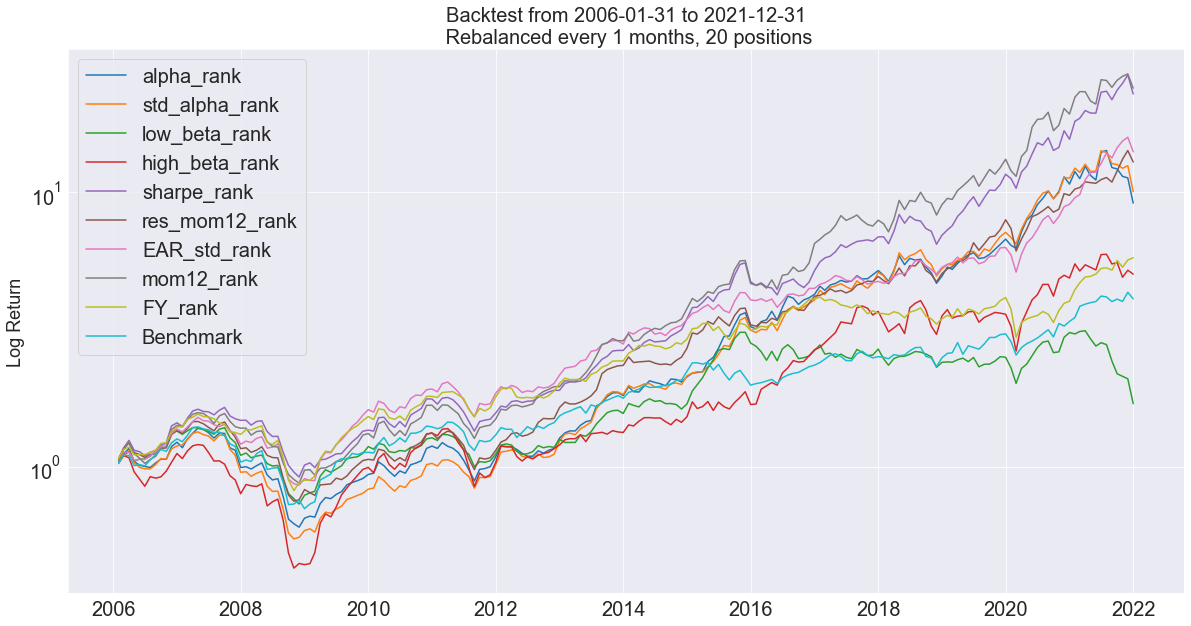

In [75]:
sns.set_style("darkgrid");
plt.figure(figsize=(20,10));
for i in result_cum.columns:
    plt.plot(result_cum[i], label = i);
start = datetime.date(result_cum.index.min());    
end = datetime.date(result_cum.index.max());
plt.yscale("log")
plt.ylabel('Log Return', fontsize=18)
plt.legend(loc=2, prop={'size': 20});
plt.title('Backtest from ' + str(start) + ' to ' + str(end) +
          "\n Rebalanced every " + str(rebal_period) + " months, " + str(top_n) + " positions", fontsize=20)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)

In [76]:
strategy_evaluation(result_cum, result_cum.columns, freq = 'M')

In [77]:
correlation_map(result_cum)


In [65]:
result_by_year = (result+1).groupby(result.index.year).prod() - 1
result_by_month = (result+1).groupby(result.index.month).mean() - 1
result_by_year

alpha_rank  std_alpha_rank  low_beta_rank  high_beta_rank  sharpe_rank  \
d                                                                              
2006    0.232262        0.194025       0.353076        0.120903     0.449211   
2007   -0.191066       -0.197959      -0.184224       -0.286289     0.021491   
2008   -0.345861       -0.386136      -0.284260       -0.447992    -0.312891   
2009    0.442767        0.413787       0.503232        1.259176     0.340449   
2010    0.268090        0.241826       0.076891        0.332610     0.298678   
2011   -0.086246       -0.013258      -0.127368       -0.218225    -0.111308   
2012    0.169946        0.220939       0.130629        0.159255     0.209775   
2013    0.428754        0.477976       0.242462        0.109622     0.397323   
2014    0.169712        0.169166       0.082893        0.140526     0.306062   
2015    0.522430        0.466205       0.665922        0.108536     0.341125   
2016    0.311574        0.288562      -0.060222        0.582695     0.114557   
2017    0.220418        0.260675       0.012139        0.378795     0.326659   
2018   -0.045992        0.030713      -0.105188       -0.037599     0.013616   
2019    0.364627        0.356437       0.043572        0.014906     0.667970   
2020    0.585778        0.573928       0.229968        0.354035     0.340937   
2021   -0.147618       -0.106101      -0.449408        0.033196     0.461327   

      res_mom12_rank  EAR_std_rank  mom12_rank  Benchmark  
d                                                          
2006        0.357273      0.376029    0.418856   0.267139  
2007       -0.139826     -0.119479   -0.023340  -0.177036  
2008       -0.290249     -0.250848   -0.296676  -0.322967  
2009        0.288346      0.783233    0.359459   0.603420  
2010        0.248459      0.189052    0.267626   0.237346  
2011       -0.136960     -0.035739   -0.109884  -0.065749  
2012        0.432894      0.165642    0.313152   0.173703  
2013        0.423320      0.296577    0.469790   0.160112  
2014        0.153725      0.231328    0.308753   0.251152  
2015        0.217953      0.176318    0.252627  -0.108085  
2016        0.270903      0.101515    0.378909   0.182139  
2017        0.180129      0.059936    0.214894   0.073869  
2018        0.024593      0.124484    0.137988  -0.010087  
2019        0.569719      0.182005    0.464563   0.223036  
2020        0.227175      0.435266    0.460698   0.109689  
2021        0.322390      0.553870    0.241363   0.208260

## Performance by rebalancing date

- measure by sharpe ratio

In [79]:
rebal_diff_df = pd.DataFrame(index = strats_test ,columns=range(1, 13))
turnover_df = pd.DataFrame(index = strats_test ,columns=range(1, 13))


for strat in strats_test:
    
    for rebal in rebal_diff_df.columns:
    
        rank_tmp = data_df.unstack(level = 'insID')[strat]
        rank_tmp = rank_tmp.loc[rank_tmp.first_valid_index():,]
        ret_df = data_df.unstack(level = 'insID')['ret'].loc[rank_tmp.first_valid_index():,]
 
        sharpe_list = []    
        rank_df_empt= rank_tmp.copy()
        rank_df_empt[:] = np.nan
        for col in rank_tmp.columns:
            rank_df_empt.loc[::rebal,col] = np.where(rank_tmp[::rebal][col]<=top_n, 1, 0)
    
        filled_rank_df = rank_df_empt.fillna(method="ffill")
    
        ret_tmp=np.multiply(filled_rank_df,ret_df)
        ret_neu_tmp=ret_tmp.sum(axis =1)/top_n
        ret_neu_tmp = pd.DataFrame(ret_neu_tmp)
        ret_neu_tmp.columns = [strat]
        sharpe_tmp = (ret_neu_tmp.mean()*12)/(ret_neu_tmp.std()*np.sqrt(12))
        turnover = filled_rank_df.diff().abs().sum().sum()
        years = len(rank_df_empt)/12
        turn_year = (turnover/top_n)/years
        
        
        turnover_df.loc[strat,rebal] = turn_year/2
        rebal_diff_df.loc[strat,rebal] = sharpe_tmp[0]
        

In [80]:
rebal_diff_df

1         2         3         4         5         6   \
QC_rank           1.073002  1.061066  1.062802  1.082641  1.016018  1.042771   
VC2_rank          0.849957  0.700024  0.781739  0.807278  0.715977  0.785575   
ear_std_mom_rank  1.325349  1.278196  1.178984  1.240941  1.184449   1.09709   
VM_rank           1.239502   1.17465  1.112672  1.058466  1.126852  1.046148   
QM_rank           1.361048  1.346462   1.31398  1.239067  1.304004  1.175876   
VQ_rank           0.963949  0.901619  0.935692  0.883217  0.975693  0.911434   
VMQ_rank          1.239405  1.165846  1.154069  1.088033  1.102524  1.118873   
twin_mom_rank     1.078384  1.105918  1.075597  1.074252  1.081986  1.111089   
mod_QM_rank       1.227771  1.173104  1.190916  1.077574  1.132445  1.153309   

                        7         8         9         10        11        12  
QC_rank           1.106216  1.000542  1.005462  1.155463  0.925361  1.085641  
VC2_rank          0.847725  0.728193  0.727282  0.957217  0.670165  0.786494  
ear_std_mom_rank  0.969194   1.02892  0.971667  1.108743  1.074395  1.076321  
VM_rank           1.079768  1.143643  1.067032  1.201346  1.085305  1.069552  
QM_rank           1.031082  1.077513  1.165479  1.241524  1.151563    1.2477  
VQ_rank           0.974695  0.930718  0.849843  1.112238  0.867591  0.883137  
VMQ_rank          1.101935  1.171469  1.055966  1.074086  1.139378   1.10133  
twin_mom_rank     1.136283  1.100569  1.096702  1.051599  1.087679  1.066452  
mod_QM_rank       1.240422  1.131175  1.120353  1.160299  1.066707  1.172873

In [81]:
turnover_df

1         2         3         4         5         6   \
QC_rank           1.222407  0.878838  0.585062  0.505394  0.560166  0.448133   
VC2_rank          2.926556  1.865975  1.338174  1.156432  1.024481  0.852697   
ear_std_mom_rank  4.304348  2.971304  2.376522  1.938261  1.625217  1.453043   
VM_rank           3.854348  2.461304  1.900435  1.556087  1.334348      1.17   
QM_rank           3.161739  2.113043  1.750435  1.450435  1.205217   1.10087   
VQ_rank           2.075104  1.415353  1.109129  0.944813   0.90249  0.790456   
VMQ_rank          3.485217  2.251304   1.71913  1.393043  1.176522  1.053913   
twin_mom_rank      3.36055  2.298165  1.874312  1.577064  1.351376  1.186239   
mod_QM_rank       2.812844  1.890826  1.519266  1.318349  1.155963  0.985321   

                        7         8         9         10        11        12  
QC_rank           0.497925  0.423237  0.418257  0.445643  0.395851  0.385892  
VC2_rank          0.819087  0.743154  0.682158  0.653527  0.590041  0.551452  
ear_std_mom_rank  1.265217  1.113913  1.027826  0.902609  0.868696  0.837391  
VM_rank           1.094348  0.943043  0.851739   0.77087  0.692609  0.695217  
QM_rank            0.99913  0.894783   0.75913   0.71087  0.697826  0.649565  
VQ_rank           0.738174  0.730705  0.663485  0.660996  0.608714  0.553942  
VMQ_rank           0.98087  0.863478  0.790435  0.683478  0.654783  0.678261  
twin_mom_rank     1.040367  0.938532  0.897248  0.787156  0.751376  0.740367  
mod_QM_rank       0.902752  0.814679  0.765138  0.704587  0.677064  0.633028

In [81]:
## Get current top N of different ranks
current_port_df = data_df.copy()#['Name']
current_port_df = current_port_df.reset_index(level='insID', drop=True)
current_port_df = current_port_df[current_port_df.index ==current_port_df.sort_index().index.unique()[-1]]
current_port_df.sort_values(by = 'ear_std_mom_rank', ascending=True)[['Name','PO','FY','ear_std_mom_rank', 'focus_mom_rank', 'res_mom12']].head(20)


Name        PO        FY  ear_std_mom_rank  \
d                                                                           
2022-02-28                  Awardit  0.126192  0.038165               1.0   
2022-02-28              Filo Mining -0.000000  0.025841               2.0   
2022-02-28                 BE Group  0.024193 -0.056359               3.0   
2022-02-28            Hanza Holding  0.004153 -0.035614               4.0   
2022-02-28              Net Insight  0.000000 -0.004192               5.0   
2022-02-28   Leading Edge Materials -0.000000  0.001095               6.0   
2022-02-28                 Raketech  0.000000  0.051393               7.0   
2022-02-28                Vertiseit  0.000000  0.133065               8.0   
2022-02-28               Björn Borg  0.019682 -0.083883               9.0   
2022-02-28            Alcadon Group  0.000000 -0.001055              10.0   
2022-02-28               NCAB Group  0.006133 -0.009742              11.0   
2022-02-28                Polygiene  0.000000  0.249111              12.0   
2022-02-28            B3 Consulting  0.034465 -0.119528              13.0   
2022-02-28                   Poolia  0.011364 -0.055750              14.0   
2022-02-28               Hexatronic  0.002072  0.035016              15.0   
2022-02-28              Beijer Alma  0.005218  0.016860              16.0   
2022-02-28              Clas Ohlson  0.013364 -0.079761              17.0   
2022-02-28            Aspire Global  0.000000 -0.041505              18.0   
2022-02-28  International Petroleum  0.000000 -0.133613              19.0   
2022-02-28                     NOTE  0.000000  0.026735              20.0   

            focus_mom_rank  res_mom12  
d                                      
2022-02-28             1.0   0.387365  
2022-02-28            25.0   0.473526  
2022-02-28             9.0   0.865231  
2022-02-28            18.0   0.626411  
2022-02-28            23.0   0.478324  
2022-02-28            34.0   0.291711  
2022-02-28             4.0   0.500193  
2022-02-28            27.0   0.352036  
2022-02-28             2.0   0.741959  
2022-02-28             6.0   0.494639  
2022-02-28            43.0   0.147467  
2022-02-28            20.0  -0.126134  
2022-02-28            11.0   0.633424  
2022-02-28            33.0   0.884731  
2022-02-28            44.0   0.327533  
2022-02-28             3.0   0.358146  
2022-02-28             5.0   0.237171  
2022-02-28            46.0   0.414522  
2022-02-28            14.0   0.526335  
2022-02-28            42.0   0.376570

##  Save returns as pandas dataframe

In [307]:
result.to_csv("data/strategy_returns.csv")